INFO:tensorflow:Restoring parameters from ./cnn_model/best.ckpt
valid set accuracy:  0.75
picture person is 4, but mis-predicted as person 6
picture person is 6, but mis-predicted as person 38
picture person is 15, but mis-predicted as person 33
picture person is 16, but mis-predicted as person 6
picture person is 29, but mis-predicted as person 15
picture person is 37, but mis-predicted as person 17


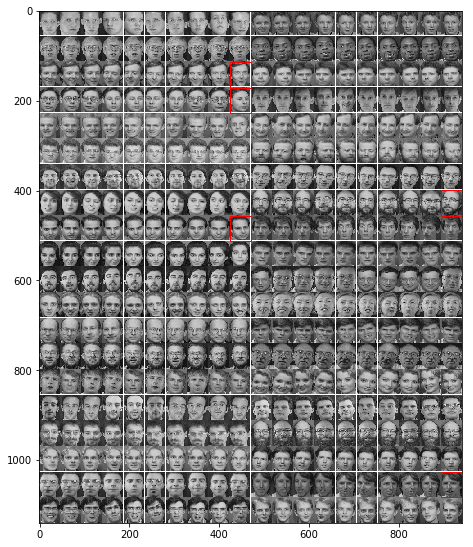

In [3]:
# -*-coding:utf-8-*-#

from PIL import Image
import numpy as np
import tensorflow as tf
import time

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

# reload(sys)
# sys.setdefaultencoding('utf-8')


def load_data(dataset_path):
    img = Image.open(dataset_path)
    # 定义一个20 × 20的训练样本，一共有40个人，每个人都10张样本照片
    img_ndarray = np.asarray(img, dtype='float64') / 256

    # 记录脸数据矩阵，57 * 47为每张脸的像素矩阵
    faces = np.empty((400, 57 * 47))

    for row in range(20):
        for column in range(20):
            faces[20 * row + column] = np.ndarray.flatten(
                img_ndarray[row * 57: (row + 1) * 57, column * 47 : (column + 1) * 47]
            )

    label = np.zeros((400, 40))
    for i in range(40):
        label[i * 10: (i + 1) * 10, i] = 1

    # 将数据分成训练集，验证集，测试集
    train_data = np.empty((320, 57 * 47))
    train_label = np.zeros((320, 40))
    vaild_data = np.empty((40, 57 * 47))
    vaild_label = np.zeros((40, 40))
    test_data = np.empty((40, 57 * 47))
    test_label = np.zeros((40, 40))

    for i in range(40):
        train_data[i * 8: i * 8 + 8] = faces[i * 10: i * 10 + 8]
        train_label[i * 8: i * 8 + 8] = label[i * 10: i * 10 + 8]

        vaild_data[i] = faces[i * 10 + 8]
        vaild_label[i] = label[i * 10 + 8]

        test_data[i] = faces[i * 10 + 9]
        test_label[i] = label[i * 10 + 9]

    return [
        (train_data, train_label),
        (vaild_data, vaild_label),
        (test_data, test_label)
    ]

def convolutional_neural_network(data):
    # 根据类别个数定义最后输出层的神经元
    n_ouput_layer = 40
    c1_dim = 32
    c2_dim = 64
    f1_dim = 1024

    kernel_shape1=[5, 5, 1, c1_dim]
    kernel_shape2=[5, 5, c1_dim, c2_dim]
    full_conn_w_shape = [7 * 6 * c2_dim, f1_dim]
    out_w_shape = [f1_dim, n_ouput_layer]

    bias_shape1=[c1_dim]
    bias_shape2=[c2_dim]
    full_conn_b_shape = [f1_dim]
    out_b_shape = [n_ouput_layer]

    data = tf.reshape(data, [-1, 57, 47, 1])

    weights = {
        "w_conv1": tf.get_variable("w_conv1", kernel_shape1, initializer=tf.random_normal_initializer()),
        "w_conv2": tf.get_variable("w_conv2", kernel_shape2, initializer=tf.random_normal_initializer()),
        "w_fc": tf.get_variable("w_fc", full_conn_w_shape, initializer=tf.random_normal_initializer()),
        "out":  tf.get_variable("w_out", out_w_shape, initializer=tf.random_normal_initializer())
    }

    biases = {
        "b_conv1": tf.get_variable("b_conv1", bias_shape1, initializer=tf.random_normal_initializer()),
        "b_conv2": tf.get_variable("b_conv2", bias_shape2, initializer=tf.random_normal_initializer()),
        "b_fc": tf.get_variable("b_fc", full_conn_b_shape, initializer=tf.random_normal_initializer()),
        "out":  tf.get_variable("b_out", out_b_shape, initializer=tf.random_normal_initializer())
    }

    # 经过第一层卷积神经网络后，得到的张量shape为：[batch, 19, 16, 32]
    conv1 = tf.nn.conv2d(data, weights['w_conv1'], strides=[1, 1, 1, 1], padding='SAME')
    ouput1 = tf.nn.relu(tf.add(conv1, biases['b_conv1']))
    layer1_output = tf.nn.max_pool(ouput1, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding="SAME")

    # 经过第二层卷积神经网络后，得到的张量shape为：[batch, 7, 6, 64]
    conv2 = tf.nn.conv2d(layer1_output, weights['w_conv2'], strides=[1, 1, 1, 1], padding='SAME')
    ouput2 = tf.nn.relu(tf.add(conv2, biases['b_conv2']))
    layer2_output = tf.nn.max_pool(ouput2, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding='SAME')

    # 讲卷积层张量数据拉成2-D张量只有有一列的列向量
    layer2_output_flatten = tf.contrib.layers.flatten(layer2_output)
    full_conn_output = tf.nn.relu(tf.add(tf.matmul(layer2_output_flatten, weights["w_fc"]), biases["b_fc"]))

    output = tf.add(tf.matmul(full_conn_output, weights["out"]), biases["out"])

    return output;

def plot(error_index, dataset_path):
    img = mpimg.imread(dataset_path)
    plt.imshow(img)
    currentAxis = plt.gca()
    for index in error_index:
        row = index // 2
        column = index % 2
        currentAxis.add_patch(
            patches.Rectangle(
                xy=(
                     47 * 9 if column == 0 else 47 * 19,
                     row * 57
                    ),
                width=47,
                height=57,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )
    )
    fig = plt.gcf()
    fig.set_size_inches(11.40, 9.42)
    plt.savefig("fig_result.png", bbox_inches="tight", dpi=100)
    plt.show()


def train():
    batch_size = 40

    dataset = load_data("./olivettifaces.gif")
    train_set_x, train_set_y = dataset[0]
    vaild_set_x, valid_set_y = dataset[1]
    test_set_x, test_set_y = dataset[2]

    X = tf.placeholder(tf.float32, [batch_size, 57 * 47])
    Y = tf.placeholder(tf.float32, [batch_size, 40])

    predict = convolutional_neural_network(X)
    cost_func = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predict, labels=Y))
    # optimizer = tf.train.GradientDescentOptimizer(1e-2).minimize(cost_func)
    optimizer = tf.train.AdamOptimizer(1e-2).minimize(cost_func)

    # 用于保存训练的最佳模型
    saver = tf.train.Saver(tf.trainable_variables(), max_to_keep=3)
    model_dir = './cnn_model'
    model_path = model_dir + '/best.ckpt'

    with tf.Session() as session:
        # 若不存在模型数据，需要训练模型参数
        if not os.path.exists(model_path + ".index"):
            session.run(tf.global_variables_initializer())

            best_loss = float('Inf')

            for epoch in range(20):
                epoch_loss = 0
                for i in range(np.shape(train_set_x)[0] // batch_size):
                    x = train_set_x[i * batch_size: (i + 1) * batch_size]
                    y = train_set_y[i * batch_size: (i + 1) * batch_size]
                    _, cost = session.run([optimizer, cost_func], feed_dict={X: x, Y: y})
                    epoch_loss += cost

                print(epoch, ' : ', epoch_loss)
                if best_loss >= epoch_loss:
                    best_loss = epoch_loss
                    if not os.path.exists(model_dir):
                        os.mkdir(model_dir)
                        print("create the directory: %s" % model_dir)
                    save_path = saver.save(session, model_path, write_meta_graph=False)
                    print("Model saved in file: %s" % save_path)

        # 恢复数据并校验和测试
        saver.restore(session, model_path)
        correct = tf.equal(tf.argmax(predict,1), tf.argmax(Y,1))
        valid_accuracy = tf.reduce_mean(tf.cast(correct,'float'))
        print('valid set accuracy: ', valid_accuracy.eval({X: vaild_set_x, Y: valid_set_y}))

        test_pred = tf.argmax(predict, 1).eval({X: test_set_x})
        test_true = np.argmax(test_set_y, 1)
        test_correct = correct.eval({X: test_set_x, Y: test_set_y})
        incorrect_index = [i for i in range(np.shape(test_correct)[0]) if not test_correct[i]]
        for i in incorrect_index:
            print('picture person is %i, but mis-predicted as person %i'
                %(test_true[i], test_pred[i]))
        plot(incorrect_index, "./olivettifaces.gif")

if __name__ == '__main__':
    train()
